In [1]:
from matplotlib.pylab import LinAlgError
from matplotlib.widgets import EllipseSelector
import numpy as np
from scipy import linalg
from sympy import use
import matrix_tools as mt
import time

from scipy import sparse as sps
from scipy.linalg import eigh,inv,lu_factor,lu_solve
from scipy.linalg.lapack import dsyev
from numpy.linalg import norm
import scipy.linalg as la
from scipy.sparse import linalg as lin
from scipy.sparse.linalg import inv as spinv
import pdb,time,warnings
np.seterr(all='raise')

#logging
import datetime
from loguru import logger
import sys        # <!- add this line
logger.remove()             # <- add this line
logger.add(sys.stdout, level="INFO")   # <- add this line
log_format = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS zz}</green> | <level>{level: <8}</level> | <yellow>Line {line: >4} ({file}):</yellow> <b>{message}</b>"
log_path=".\logs\log-"+str(datetime.datetime.now()).replace(" ","-").replace(".","-").replace(":","-")+".log"
logger.add(log_path, level="TRACE", format=log_format, colorize=False, backtrace=True, diagnose=True)
# Lanczos algorithm
def lanczos_1(A, v0=None,maxiter=None):
    start_time=time.time()
    # First iteration steps
    x, y = [], []
    n = A.shape[0]
    if maxiter is None:maxiter=n
    v0 = np.random.random((n, 1))
    v1, beta = 0.0, 0.0

    for i in range(maxiter):
        # Iteration steps
        w_prime = np.dot(A, v0)
        conj = np.matrix.conjugate(w_prime)
        alpha = np.dot(conj, v0)
        w = w_prime - alpha * v0 - beta * v1
        beta = np.linalg.norm(w)
        x.append(np.linalg.norm(alpha))

        # Reset
        if i < (maxiter-1):
            y.append(beta)
        v1 = v0
        v0 = w/beta
    end_time=time.time()
    eigen_values, eigen_vectors=np.eig(mt.tridiag(y, x, y))

    logger.success('Lancsoz Method '+ str(np.sort(eigen_values[0]))+'; time = '+str(end_time-start_time)+ " seconds.")

    return eigen_values,eigen_vectors,end_time-start_time, maxiter
def lanczos_2(A, maxiter=None):

    start_time=time.time()
    n = A.shape[0]
    if maxiter is None:maxiter=n

    v = np.random.random((n, 1))
    v = v / np.linalg.norm(v)
    v_old = np.zeros((n, 1))
    beta = np.zeros(maxiter)
    alpha = np.zeros(maxiter)
    for j in range(maxiter-1):
        w = A.dot(v)
        alpha[j] = w.T.dot(v)
        w = w - alpha[j] * v - beta[j] * v_old
        beta[j+1] = np.linalg.norm(w)
        v_old = v.copy()
        v = w / beta[j+1]
    w = A.dot(v)
    alpha[maxiter-1] = w.T.dot(v)
    A = np.diag(beta[1:], k=-1) + np.diag(beta[1:], k=1) + np.diag(alpha[:], k=0)
    eigen_values, eigen_vectors = np.linalg.eigh(A)
    end_time=time.time()
    logger.success('Lancsoz Method '+ str(np.sort(eigen_values[0]))+'; time = '+str(end_time-start_time)+ " seconds.")
    return eigen_values,eigen_vectors,end_time-start_time, maxiter

def block_power_method(A, k, tol=1e-6, maxiter=100):

    n = A.shape[0]
    residauls=[]
    approx_egien_values=[]
    # Check if k is valid
    if k < 1 or k > n:
        print("Invalid value of k")
        return None
    start_time=time.time()
    # Initialize a random matrix Q of size n B k
    Q = np.random.rand(n, k)

    # Orthonormalize Q using QR decomposition
    Q, _ = np.linalg.qr(Q)

    # Initialize a variable to store the eigenvalues
    lambdas = np.zeros(k)

    # Initialize a counter for iterations
    iter = 0

    # Loop until convergence or maximum iterations
    while iter < maxiter:
        # Perform the matrix multiplication AQ
        Z = A @ Q

        # Solve the linear system Q^T Z = Q^T A Q = Lambda
        # Lambda is a diagonal matrix of eigenvalues
        # We can use np.linalg.solve to find Lambda
        Lambda = np.linalg.solve(Q.T, Z.T).T

        # Extract the diagonal elements of Lambda
        lambdas_new = np.diag(Lambda)

        # Check the relative change of eigenvalues
        diff=lambdas - lambdas_new
        res=np.linalg.norm(diff)
        approx_egien_values.append(lambdas_new)
        residauls.append(res)
        if  res < tol:
            logger.info('Block power method converged at iteration number = '+ str(iter))
            # Converged
            break

        # Update the eigenvalues
        lambdas = lambdas_new

        # Orthonormalize Z using QR decomposition
        Q, _ = np.linalg.qr(Z)

        # Increment the iteration counter
        iter += 1

    end_time=time.time()
    logger.success("Block Power method  = "+ str(lambdas)+"; time = "+str(end_time-start_time)+" seconds.")

    # Return the eigenvalues and eigenvectors
    return lambdas, Q, end_time-start_time, iter,residauls,approx_egien_values

def subspace_iteration_1(A, k=1, Y0=None, maxiter=100,tol=1e-6):
    start_time=time.time()
    n=A.shape[0]
    residauls=[]
    approx_egien_values=[]
    if Y0 is None:
        Y0 = np.random.random((n, k))

    Y0, _ = np.linalg.qr(Y0)
    Y = Y0.copy()
    Y_old = Y0.copy()
    err = []
    i=0
    while i<maxiter:
        B = A.dot(Y)
        Y, E = np.linalg.qr(B)
        error=np.linalg.norm(Y_old - Y.dot(Y.T.dot(Y_old)))
        residauls.append(error)
        approx_egien_values.append(np.diag(E))
        i+=1
        if(error<tol):
            logger.info('Subspace_1 converged at iteration number = '+ str(i))
            break
        Y_old = Y.copy()
        end_time=time.time()

    # approx = np.dot(Y.T,np.dot(A,Y))/np.linalg.norm(Y)

    logger.success("Subspace iteration = "+ str(np.diag(E))+"; time = "+str(end_time-start_time)+" seconds.")

    return np.diag(E), Y,end_time-start_time, i,residauls,approx_egien_values

def subspace_iteration_2(A, k=1, V0=None, maxiter=1000,tol=1e-4):

    start_time=time.time()
    n=A.shape[0]

    if V0 is None:
        V0 = np.random.random((n, k))

    V=V0
    residuals = []
    approx_egien_values=[]
    err=100
    i=0
    while i<maxiter:
        B = A.dot(V)
        Q, R = np.linalg.qr(B)
        V=Q[:, :k]
        E=R[:k, :]
        err=np.linalg.norm(A.dot(V)-V.dot(E))
        residuals.append(err)
        approx_egien_values.append(np.diag(E))
        i+=1
        if(err<tol):
            logger.info('Subspace_2 converged at iteration number = '+ str(i))
            break

    end_time=time.time()


    logger.success("Subspace iteration_2 = "+ str(np.diag(E))+"; time = "+str(end_time-start_time)+" seconds.")

    return E, V,end_time-start_time,i, residuals, approx_egien_values

def rayleigh_quotient_iteration(A, tol=1e-10, rcoeff=0, B=None):
    n=A.shape[0]
    residuals=[]

    if B is None:
        B=np.random.rand(n)
    B = B / la.norm(B)

    # the solve function in scipy.linalg solves a linear system
    start_time=time.time()
    try:
        C = la.solve(A - rcoeff * np.eye(n), B)

    except la.LinAlgError as exc:
        # logger.exception(exc)
        logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
        try:
            LU, piv = lu_factor(A - rcoeff * np.eye(n))
            C=lu_solve((LU,piv),B)
        except np.linalg.LinAlgError as exc:
            # logger.exception(exc)
            logger.warning("lu_solve and lu_factor failed. please try use_inverse")
            raise exc



    lambda_ = C.T @ B
    rcoeff = rcoeff + 1 / lambda_
    err = la.norm(C - lambda_ * B) / la.norm(C)
    residuals.append(err)
    j=0
    while err > tol:
        j+=1
        B = C / la.norm(C)
        try:
            C = la.solve(A - rcoeff * np.eye(n), B)

        except la.LinAlgError as exc:
            # logger.exception(exc)
            logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
            try:
                LU, piv = lu_factor(A - rcoeff * np.eye(n))
                C=lu_solve((LU,piv),B)
            except np.linalg.LinAlgError as exc:
                # logger.exception(exc)
                logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                raise exc
        lambda_ = C.T @ B
        rcoeff = rcoeff + 1 / lambda_
        err = la.norm(C - lambda_ * B) / la.norm(C)

    logger.info('Rayleigh Quotient Iteration converged at iteration number = '+ str(j))
    # approx=np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
    end_time=time.time()

    # logger.success(' Reigh iteration '+ str(approx)+'; time = '+str(end_time-start_time)+ " seconds.")
    logger.success('Rayleigh Quotient Iteration = '+ str(rcoeff)+'; time = '+str(end_time-start_time)+ " seconds.")

    return rcoeff,B,residuals

def power_iteration(A,tol=1e-10,maxiter=1000,use_rayleigh=False,calc_min=False,use_inverse=True,Sigma=0,norm_c_mode='2',output_approx_instead_of_residuals=False):
    if calc_min:
        method_name='Inverse iteration: use_inverse = {}, use_rayleigh = {}, norm_c_mode = {}'.format(use_inverse, use_rayleigh, norm_c_mode)
    else:
        method_name='Power iteration: use_inverse = {}, use_rayleigh = {}, norm_c_mode = {}'.format(use_inverse, use_rayleigh, norm_c_mode)
    n=A.shape[0]
    residuals=[]
    approx_egien_values=[]
    A_orginal=A.copy()
    start_time = time.time()
    A_Sigma=A_orginal-Sigma*np.eye(n)
    A=A_Sigma.copy()
    # if not calc_min and use_inverse:
    #     logger.warning('Ignoring use_inverse. Use_inverse is an option when calc_min is set to True.')

    if calc_min:
        if use_inverse:
            try :
                A=np.linalg.inv(A)
            except np.linalg.LinAlgError as exc:
                # logger.exception(exc)
                logger.warning("Matrix is singuar. Trying to use psudo inverse of A. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                A=np.linalg.pinv(A)
        else:
            if not use_rayleigh:

                     LU,piv=lu_factor(A)
    else:
        if use_rayleigh:
            logger.warning('calc_min is off. use_rayleigh is ignored.')




    # Build a random trial vector
    B=np.random.rand(n)
    B=B/la.norm(B)
    j=0
    rcoeff=0
    norm_mat=np.zeros(2)
    while j<maxiter:
        if calc_min:
            if use_rayleigh:

                rcoeff = np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
            if not use_inverse:
                if use_rayleigh:

                    try:
                        C=la.solve(A_Sigma-rcoeff*np.eye(n),B)

                    except (la.LinAlgError, la.LinAlgWarning) as exc:
                        # logger.exception(exc)
                        logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
                        try:
                            LU, piv = la.lu_factor(A_Sigma-rcoeff*np.eye(n))
                            C=la.lu_solve((LU,piv),B)
                            if(np.any(C==None) or np.any(C==np.inf)):
                                logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                                A_new=A_Sigma-rcoeff*np.eye(n)
                                try :
                                    A_new=np.linalg.inv(A_new)
                                except np.linalg.LinAlgError as exc:

                                    # logger.exception(exc)
                                    logger.warning("Matrix is singuar. Trying to use psudo inverse of A_new. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                                    A_new=np.linalg.pinv(A_new)
                                C =  np.dot(A_new,B)  if use_rayleigh else np.dot(A,B)

                        except (la.LinAlgError, la.LinAlgWarning)  as exc:
                            # logger.exception(exc)
                            logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                            # raise exc
                else:
                    C=lu_solve((LU,piv),B)
                idx=np.argmax(np.abs(C))
            else:
                if use_rayleigh:
                    A_new=A_Sigma-rcoeff*np.eye(n)
                    try :
                        A_new=np.linalg.inv(A_new)
                    except np.linalg.LinAlgError as exc:

                        # logger.exception(exc)
                        logger.warning("Matrix is singuar. Trying to use psudo inverse of A_new. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                        A_new=np.linalg.pinv(A_new)

                C =  np.dot(A_new,B)  if use_rayleigh else np.dot(A,B)
        else:
            C = np.dot(A,B)


        norm_c = C[idx] if ( not use_inverse and calc_min and norm_c_mode=='max_abs') else np.linalg.norm(C)
        B = C/(norm_c)
        j=j+1
        # print(j)
        if j==1:
            logger.trace('just the first iteration, give me a break')
            norm_mat[0]=norm_c
        else:
            norm_mat[1] = norm_mat[0]
            norm_mat[0] = norm_c
            if( calc_min and use_rayleigh and not use_inverse):
                diff=la.norm(C-(C.T@B)*B)
            else:
                diff = abs(norm_mat[1] - norm_mat[0])
            residuals.append(diff)
            if output_approx_instead_of_residuals:
                approx = 1/norm_c if (calc_min and not use_inverse and norm_c_mode=='max_abs') else np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
                if calc_min and use_inverse: approx=1./approx
                approx += Sigma
                approx_egien_values.append(approx)
            if diff < tol:
                logger.info('Power iteration converged at iteration number = '+ str(j))
                break
            else:
                continue

    approx = 1/norm_c if (calc_min and not use_inverse and norm_c_mode=='max_abs') else np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
    if calc_min and use_inverse: approx=1./approx
    approx += Sigma
    end_time = time.time()

    logger.success(method_name+' = '+ str(approx)+'; time = '+str(end_time-start_time)+ " seconds.")



    w, v = np.linalg.eig(A_orginal)
    w=np.sort(w)
    diff = (w[0] if calc_min else w[-1])- approx
    logger.trace('exact eigenvalue='+(str(w[0]) if calc_min else str(w[-1])))
    logger.trace('Residual = '+ str(diff))
    if output_approx_instead_of_residuals: return approx,B,end_time-start_time,j,residuals,approx_egien_values
    else:
        return approx,B,end_time-start_time,j,residuals


def davidson_1(A,v0=None,tol=1e-10,maxiter=1000):
    '''
    The Davidson's algorithm.

    Parameters:
        :A: matrix, the input matrix.
        :v0: 2D array, the initial subspace.
        :tol: float, the tolerence.
        :maxiter: int, the maximum number of iteration times.

    Return:
        tuple of (e,v), e is the eigenvalues and v the eigenvector e is the eigenvalues and v the eigenvectors.
    '''


    start_time = time.time()
    N=A.shape[0]
    # A=A.tocsr()
    DA_diag=A.diagonal()
    if v0 is None:
        v0=np.random.random((N,1))
    elif np.ndim(v0)==1:
        v0=v0[:,np.newaxis]
    v0=mt.normalize(v0)
    Av=A.dot(v0)
    AV=Av
    V=v0
    #initialise projected matrix.
    G=v0.T.conj().dot(Av)
    for i in range(maxiter):
        ei,vi=np.linalg.eig(G)
        #compute largest Ritz value theta, and Ritz vector u.
        imax=np.argmax(ei)
        theta,u=ei[imax],V.dot(vi[:,imax:imax+1])
        #get the residual
        r=AV.dot(vi[:,imax:imax+1])-theta*u
        if norm(r)<tol:
            break

        if(i%20==0):logger.trace(str(i)+' ||r|| = '+ str(norm(r))+', eigen value = '+str(theta))
        #compute the correction vector z
        z=-1./(DA_diag-theta)[:,np.newaxis]*r
        z=mt.mgs(z,V)
        z=mt.normalize(z)

        Av=A.dot(z)
        #add z to search space.
        AV=np.concatenate([AV,Av],axis=1)
        #update G, G=UAU.H
        gg=[[G,V.T.conj().dot(Av)],[Av.T.conj().dot(V),Av.T.conj().dot(z)]]
        G=np.bmat([[G,V.T.conj().dot(Av)],[Av.T.conj().dot(V),Av.T.conj().dot(z)]])
        V=np.concatenate([V,z],axis=1)
    end_time = time.time()

       # End of block Davidson. Print results.

    logger.success("davidson_1 = "+ str(theta)+"; time = "+
        str(end_time - start_time)+ " seconds.")


    return theta,u
def davidson_2(A,k=None,n_eigen=1,tol=1e-10,maxiter=1000):
    ''' Block Davidson, Joshua Goings (2013)

    Block Davidson method for finding the first few
	lowest eigenvalues of a large, diagonally dominant,
    sparse Hermitian matrix (e.g. Hamiltonian)
'''
    n=A.shape[0]
    maxiter = n//2				# Maximum number of iterations

    if k is None:k=2*n_eigen
    t = np.eye(n,k)			# set of k unit vectors as guess
    V = np.zeros((n,n))		# array of zeros to hold guess vec
    I = np.eye(n)			# identity matrix same dimen as A
    residuals=[]
    # Begin block Davidson routine

    start_time = time.time()

    for maxiter in range(k,maxiter,k):
        if maxiter <= k:
            for j in range(0,k):
                V[:,j] = t[:,j]/np.linalg.norm(t[:,j])
            theta_old = 1
        elif maxiter > k:
            theta_old = theta[:n_eigen]
        V[:,:maxiter],R = np.linalg.qr(V[:,:maxiter])
        T = np.dot(V[:,:maxiter].T,np.dot(A,V[:,:maxiter]))
        THETA,S = np.linalg.eig(T)
        idx = THETA.argsort()
        theta = THETA[idx]
        s = S[:,idx]
        for j in range(0,k):
            w = np.dot((A - theta[j]*I),np.dot(V[:,:maxiter],s[:,j]))
            q = w/(theta[j]-A[j,j])
            V[:,(maxiter+j)] = q
        norm = np.linalg.norm(theta[:n_eigen] - theta_old)
        residuals.append(norm)
        if norm < tol:
            break

    end_time = time.time()

    # End of block Davidson. Print results.

    logger.success("davidson_2 = "+ str(theta[:n_eigen])+"; time = "+
       str(end_time - start_time)+" seconds.")
    return theta[:n_eigen], s[:n_eigen],residuals
def davidson_3(A,k=None,n_eigen=1,tol=1e-10,maxiter=1000):
    '''
    The Block Davidson method ca be used to solve for a number of the lowest or highest few Eigenvalues of a symmetric matrix.
    https://github.com/sreeganb/davidson_algorithm/
    Important: Input matrix must be symmetric
    '''
    #-------------------------------------------------------------------------------
# Attempt at Block Davidson algorithm
# Sree Ganesh (sreeuci@gmail.com)
# Summer 2017
#-------------------------------------------------------------------------------


    n=A.shape[0]
    # Setup the subspace trial vectors
    if k is None:k=2*n_eigen
    # logger.trace('No. of start vectors:'+str(k))
    # logger.trace('No. of desired Eigenvalues:'+str(n_eigen))
    t = np.eye(n,k) # initial trial vectors
    v = np.zeros((n,n)) # holder for trial vectors as iterations progress
    I = np.eye(n) # n*n identity matrix
    ritz = np.zeros((n,n))
    f = np.zeros((n,n))
    residuals=[]
    #-------------------------------------------------------------------------------
    # Begin iterations
    #-------------------------------------------------------------------------------
    start = time.time()
    iter = 0
    for maxiter in range(k,maxiter,k):
        iter = iter + 1
        # logger.trace("Iteration no:"+ str(iter))
        if iter==1:  # for first iteration add normalized guess vectors to matrix v
            for eigen_values in range(maxiter):
                v[:,eigen_values] = t[:,eigen_values]/(np.linalg.norm(t[:,eigen_values]))
        # Matrix-vector products, form the projected Hamiltonian in the subspace
        T = np.linalg.multi_dot([v[:,:maxiter].T,A,v[:,:maxiter]]) # selects fastest evaluation order
        w, vects = np.linalg.eig(T) # Diagonalize the subspace Hamiltonian
        j = 0
        s = w.argsort()
        ss = w[s]
        #***************************************************************************
        # For each eigenvector of T build a Ritz vector, precondition it and check
        # if the norm is greater than a set threshold.
        #***************************************************************************
        for i in range(maxiter): #for each new eigenvector of T
            f = np.diag(1./ np.diag((np.diag(np.diag(A)) - w[i]*I)))
    #        logger.trace(f)
            ritz[:,i] = np.dot(f,np.linalg.multi_dot([(A-w[i]*I),v[:,:maxiter],vects[:,i]]))
            if np.linalg.norm(ritz[:,i]) > 1e-7 :
                ritz[:,i] = ritz[:,i]/(np.linalg.norm(ritz[:,i]))
                v[:,maxiter+j] = ritz[:,i]
                j = j + 1
        q, r = np.linalg.qr(v[:,:maxiter+j-1])
        for kk in range(maxiter+j-1):
            v[:,kk] = q[:,kk]
        # for i in range(n_eigen):
        #     logger.trace(ss[i])
        if iter==1:
            check_old = ss[:n_eigen]
            check_new = 1
        elif iter==2:
            check_new = ss[:n_eigen]
        else:
            check_old = check_new
            check_new = ss[:n_eigen]
        check = np.linalg.norm(check_new - check_old)
        residuals.append(check)
        if check < tol:
            logger.info('Block Davidson converged at iteration number = '+str(iter))
            break
    end = time.time()
    logger.success("davidson_3 = "+ str(ss[:n_eigen])+"; time = "+str(end-start)+" seconds.")

    return ss[:n_eigen],v[:n_eigen],residuals
def get_initial_guess(A,n_eigen):
    nrows, ncols = A.shape
    d = np.diag(A)
    index = np.argsort(d)
    guess = np.zeros((nrows,n_eigen))
    for i in range(n_eigen):
        guess[index[i],i] = 1

    return guess
def jacobi_correction(uj,A,thetaj):
    I = np.eye(A.shape[0])
    Pj = I-np.dot(uj,uj.T)
    rj = np.dot((A - thetaj*I),uj)

    w = np.dot(Pj,np.dot((A-thetaj*I),Pj))
    return np.linalg.solve(w,rj)
def davidson_4(A, n_eigen=1, tol=1E-6, maxiter = 1000, jacobi=False,non_hermitian=False,hamiltonian=False,output_approx_instead_of_residuals=False):
    """Davidosn solver for eigenvalue problem
    https://github.com/NLESC-JCER/DavidsonPython/tree/master

    Args :
        A (numpy matrix) : the matrix to diagonalize
        n_eigen (int)     : the number of eigenvalue requied
        tol (float)      : the rpecision required
        maxiter (int)    : the maximum number of iteration
        jacobi (bool)    : do the jacobi correction
    Returns :
        eigenvalues (array) : lowest eigenvalues
        eigenvectors (numpy.array) : eigenvectors
    """
    n = A.shape[0]
    k = 2*n_eigen            # number of initial guess vectors
    V = np.eye(n,k)         # set of k unit vectors as guess
    I = np.eye(n)           # identity matrix same dimen as A
    Adiag = np.diag(A)
    residuals=[]
    approx_egien_values=[]
    start_time = time.time()

    V = get_initial_guess(A,k)

    # print('\n'+'='*20)
    # logger.trace("= Davidson Solver ")
    # print('='*20)

    #invA = np.linalg.inv(A)
    #inv_approx_0 = 2*I - A
    #invA2 = np.dot(invA,invA)
    #invA3 = np.dot(invA2,invA)

    norm = np.zeros(k if hamiltonian else n_eigen)

    # Begin block Davidson routine
    # logger.trace("iter size norm"+str(tol))
    i=0
    while i<maxiter:

        # QR of V t oorthonormalize the V matrix
        # this uses GrahmShmidtd in the back
        V,R = np.linalg.qr(V)

        # form the projected matrix

        T = np.dot(V.conj().T if hamiltonian or non_hermitian else V.T,np.dot(A,V))



        # Diagonalize the projected matrix
        theta,s = np.linalg.eigh(T)

        if hamiltonian or non_hermitian:
            # print(np.diag(T))
            # organize the eigenpairs
            index = np.argsort(theta.real)
            theta  = theta[index]
            s = s[:,index]

        # Ritz eigenvector
        q = np.dot(V,s)

        # compute the residual append append it to the
        # set of eigenvectors
        if hamiltonian:
            ind0 = np.where(theta>0, theta, np.inf).argmin()

        for _j in range(k if hamiltonian else n_eigen):
            j = ind0+_j-int(0.25*k) if hamiltonian else +_j

            # residue vetor
            res = np.dot((A - theta[j]*I),q[:,j])
            norm[_j] = np.linalg.norm(res)

            # correction vector
            if jacobi:
            	delta = jacobi_correction(q[:,j],A,theta[j])
            else:
                # print(res)
                # print(theta[j])
                delta = res / (theta[j]-Adiag+1E-16)
                #C = inv_approx_0 + theta[j]*I
                #delta = -np.dot(C,res)
            # print(delta)

            if(np.all(delta!=0)):delta /= np.linalg.norm(delta)

            # expand the basis
            V = np.hstack((V,delta.reshape(-1,1)))

        # comute the norm to see if eigenvalue converge
        # logger.trace(str(i)+" "+str(V.shape[1])+" "+ str(np.max(norm)))
        residuals.append(np.max(norm))
        if output_approx_instead_of_residuals:
            if not hamiltonian: ind0=0
            approx_egien_values.append(theta[ind0:ind0+n_eigen])
        i+=1

        if np.all(norm < tol):
            logger.info("Davidson_4 has converged in iteration number = "+str(i))
            break
    end_time = time.time()
    if not hamiltonian: ind0=0
    logger.success("Davidson_4 = "+ str(theta[ind0:n_eigen+ind0])+"; time = "+str(end_time-start_time)+" seconds.")

    if output_approx_instead_of_residuals:
        return theta[ind0:ind0+n_eigen], q[:,ind0:ind0+n_eigen],end_time-start_time,i,residuals,approx_egien_values
    else:
        return theta[ind0:ind0+n_eigen], q[:,ind0:ind0+n_eigen],end_time-start_time,i,residuals
def numpy_eigen(A,l,u):
      # Begin Numpy diagonalization of A

    start_time = time.time()

    E,Vec = np.linalg.eig(A)
    idx=np.argsort(E)


    end_time = time.time()
    E = E[idx]
    Vec=Vec[idx]

    # End of Numpy diagonalization. Print results.

    logger.success("numpy = "+ str(E[l:u])+"; time = "+
       str(end_time - start_time) + " seconds")
    return E[l:u],Vec[l:u],end_time - start_time,0,np.zeros((A.shape[0], abs(l-u))),E[l:u]

def main():
    A=mt.symmetric_sparse(100)

    nr=numpy_eigen(A,99,100)
    print(nr[1])
    r=subspace_iteration_1(A,k=1,maxiter=100)
    print(r[1].T)
    print(nr[1]-r[1].T)
if __name__=='__main__':
    main()

ModuleNotFoundError: No module named 'matrix_tools'

In [ ]:
def rayleigh_quotient_iteration(A, tol=1e-10, rcoeff=0, B=None):
    n=A.shape[0]
    residuals=[]

    if B is None:
        B=np.random.rand(n)
    B = B / la.norm(B)

    # the solve function in scipy.linalg solves a linear system
    start_time=time.time()
    try:
        C = la.solve(A - rcoeff * np.eye(n), B)

    except la.LinAlgError as exc:
        # logger.exception(exc)
        logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
        try:
            LU, piv = lu_factor(A - rcoeff * np.eye(n))
            C=lu_solve((LU,piv),B)
        except np.linalg.LinAlgError as exc:
            # logger.exception(exc)
            logger.warning("lu_solve and lu_factor failed. please try use_inverse")
            raise exc



    lambda_ = C.T @ B
    rcoeff = rcoeff + 1 / lambda_
    err = la.norm(C - lambda_ * B) / la.norm(C)
    residuals.append(err)
    j=0
    while err > tol:
        j+=1
        B = C / la.norm(C)
        try:
            C = la.solve(A - rcoeff * np.eye(n), B)

        except la.LinAlgError as exc:
            # logger.exception(exc)
            logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
            try:
                LU, piv = lu_factor(A - rcoeff * np.eye(n))
                C=lu_solve((LU,piv),B)
            except np.linalg.LinAlgError as exc:
                # logger.exception(exc)
                logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                raise exc
        lambda_ = C.T @ B
        rcoeff = rcoeff + 1 / lambda_
        err = la.norm(C - lambda_ * B) / la.norm(C)

    logger.info('Rayleigh Quotient Iteration converged at iteration number = '+ str(j))
    # approx=np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
    end_time=time.time()

    # logger.success(' Reigh iteration '+ str(approx)+'; time = '+str(end_time-start_time)+ " seconds.")
    logger.success('Rayleigh Quotient Iteration = '+ str(rcoeff)+'; time = '+str(end_time-start_time)+ " seconds.")

    return rcoeff,B,residuals

def power_iteration(A,tol=1e-10,maxiter=1000,use_rayleigh=False,calc_min=False,use_inverse=True,Sigma=0,norm_c_mode='2',output_approx_instead_of_residuals=False):
    if calc_min:
        method_name='Inverse iteration: use_inverse = {}, use_rayleigh = {}, norm_c_mode = {}'.format(use_inverse, use_rayleigh, norm_c_mode)
    else:
        method_name='Power iteration: use_inverse = {}, use_rayleigh = {}, norm_c_mode = {}'.format(use_inverse, use_rayleigh, norm_c_mode)
    n=A.shape[0]
    residuals=[]
    approx_egien_values=[]
    A_orginal=A.copy()
    start_time = time.time()
    A_Sigma=A_orginal-Sigma*np.eye(n)
    A=A_Sigma.copy()
    # if not calc_min and use_inverse:
    #     logger.warning('Ignoring use_inverse. Use_inverse is an option when calc_min is set to True.')

    if calc_min:
        if use_inverse:
            try :
                A=np.linalg.inv(A)
            except np.linalg.LinAlgError as exc:
                # logger.exception(exc)
                logger.warning("Matrix is singuar. Trying to use psudo inverse of A. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                A=np.linalg.pinv(A)
        else:
            if not use_rayleigh:

                     LU,piv=lu_factor(A)
    else:
        if use_rayleigh:
            logger.warning('calc_min is off. use_rayleigh is ignored.')




    # Build a random trial vector
    B=np.random.rand(n)
    B=B/la.norm(B)
    j=0
    rcoeff=0
    norm_mat=np.zeros(2)
    while j<maxiter:
        if calc_min:
            if use_rayleigh:

                rcoeff = np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
            if not use_inverse:
                if use_rayleigh:

                    try:
                        C=la.solve(A_Sigma-rcoeff*np.eye(n),B)

                    except (la.LinAlgError, la.LinAlgWarning) as exc:
                        # logger.exception(exc)
                        logger.warning("la.solve failed. Trying to use la_factor and la_solve.")
                        try:
                            LU, piv = la.lu_factor(A_Sigma-rcoeff*np.eye(n))
                            C=la.lu_solve((LU,piv),B)
                            if(np.any(C==None) or np.any(C==np.inf)):
                                logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                                A_new=A_Sigma-rcoeff*np.eye(n)
                                try :
                                    A_new=np.linalg.inv(A_new)
                                except np.linalg.LinAlgError as exc:

                                    # logger.exception(exc)
                                    logger.warning("Matrix is singuar. Trying to use psudo inverse of A_new. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                                    A_new=np.linalg.pinv(A_new)
                                C =  np.dot(A_new,B)  if use_rayleigh else np.dot(A,B)

                        except (la.LinAlgError, la.LinAlgWarning)  as exc:
                            # logger.exception(exc)
                            logger.warning("lu_solve and lu_factor failed. please try use_inverse")
                            # raise exc
                else:
                    C=lu_solve((LU,piv),B)
                idx=np.argmax(np.abs(C))
            else:
                if use_rayleigh:
                    A_new=A_Sigma-rcoeff*np.eye(n)
                    try :
                        A_new=np.linalg.inv(A_new)
                    except np.linalg.LinAlgError as exc:

                        # logger.exception(exc)
                        logger.warning("Matrix is singuar. Trying to use psudo inverse of A_new. Also you can turn off use_inverse flag for using lu_factor and lu_solver to solve the linear system. ")
                        A_new=np.linalg.pinv(A_new)

                C =  np.dot(A_new,B)  if use_rayleigh else np.dot(A,B)
        else:
            C = np.dot(A,B)


        norm_c = C[idx] if ( not use_inverse and calc_min and norm_c_mode=='max_abs') else np.linalg.norm(C)
        B = C/(norm_c)
        j=j+1
        # print(j)
        if j==1:
            logger.trace('just the first iteration, give me a break')
            norm_mat[0]=norm_c
        else:
            norm_mat[1] = norm_mat[0]
            norm_mat[0] = norm_c
            if( calc_min and use_rayleigh and not use_inverse):
                diff=la.norm(C-(C.T@B)*B)
            else:
                diff = abs(norm_mat[1] - norm_mat[0])
            residuals.append(diff)
            if output_approx_instead_of_residuals:
                approx = 1/norm_c if (calc_min and not use_inverse and norm_c_mode=='max_abs') else np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
                if calc_min and use_inverse: approx=1./approx
                approx += Sigma
                approx_egien_values.append(approx)
            if diff < tol:
                logger.info('Power iteration converged at iteration number = '+ str(j))
                break
            else:
                continue

    approx = 1/norm_c if (calc_min and not use_inverse and norm_c_mode=='max_abs') else np.dot(B.T,np.dot(A,B))/np.linalg.norm(B)
    if calc_min and use_inverse: approx=1./approx
    approx += Sigma
    end_time = time.time()
    logger.success(method_name+' = '+ str(approx)+'; time = '+str(end_time-start_time)+ " seconds.")
    w, v = np.linalg.eig(A_orginal)
    w=np.sort(w)
    diff = (w[0] if calc_min else w[-1])- approx
    logger.trace('exact eigenvalue='+(str(w[0]) if calc_min else str(w[-1])))
    logger.trace('Residual = '+ str(diff))
    if output_approx_instead_of_residuals: return approx,B,end_time-start_time,j,residuals,approx_egien_values
    else:
        return approx,B,end_time-start_time,j,residuals


In [ ]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve, qr

def power_iteration(A, tol=1e-10, maxiter=1000):
    """Power Iteration Method to find the dominant eigenvalue and eigenvector."""
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)

    for _ in range(maxiter):
        w = np.dot(A, v)
        v_next = w / np.linalg.norm(w)
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    eigenvalue = np.dot(v.T, np.dot(A, v))
    return eigenvalue, v

def inverse_iteration(A, tol=1e-10, maxiter=1000):
    """Inverse Iteration Method to find the smallest eigenvalue and eigenvector."""
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)

    for _ in range(maxiter):
        w = np.linalg.solve(A, v)
        v_next = w / np.linalg.norm(w)
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    eigenvalue = np.dot(v.T, np.dot(A, v))
    return eigenvalue, v

def shifted_inverse_iteration(A, shift, tol=1e-10, maxiter=1000):
    """Shifted Inverse Iteration to compute eigenvalues near a given shift."""
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    shifted_A = A - shift * np.eye(n)

    for _ in range(maxiter):
        w = np.linalg.solve(shifted_A, v)
        v_next = w / np.linalg.norm(w)
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    eigenvalue = np.dot(v.T, np.dot(A, v))
    return eigenvalue, v

def rayleigh_quotient_iteration(A, tol=1e-10, maxiter=1000):
    """Rayleigh Quotient Iteration with regularization to avoid singularity."""
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    lambda_approx = np.dot(v.T, np.dot(A, v))

    for _ in range(maxiter):
        shifted_A = A - lambda_approx * np.eye(n)

        try:
            # Solve for the new eigenvector
            w = np.linalg.solve(shifted_A, v)
        except np.linalg.LinAlgError:
            # Handle singular matrix case using pseudo-inverse
            w = np.dot(np.linalg.pinv(shifted_A), v)

        v_next = w / np.linalg.norm(w)
        lambda_next = np.dot(v_next.T, np.dot(A, v_next))

        if np.linalg.norm(v_next - v) < tol:
            break

        v, lambda_approx = v_next, lambda_next

    return lambda_approx, v


def simultaneous_iteration(A, tol=1e-10, maxiter=1000):
    """Simultaneous Iteration for computing all eigenvalues and eigenvectors."""
    n = A.shape[0]
    V = np.random.rand(n, n)
    Q, _ = np.linalg.qr(V)  # Orthonormalize initial matrix

    for _ in range(maxiter):
        W = np.dot(A, Q)
        Q_next, R = np.linalg.qr(W)
        if np.linalg.norm(Q_next - Q) < tol:
            break
        Q = Q_next

    eigenvalues = np.diag(np.dot(Q.T, np.dot(A, Q)))
    return eigenvalues, Q

def qr_method(A, tol=1e-10, maxiter=1000):
    """QR Method for computing all eigenvalues."""
    Ak = A.copy()
    for _ in range(maxiter):
        Q, R = qr(Ak)
        Ak = np.dot(R, Q)
        off_diagonal = np.sqrt(np.sum(np.tril(Ak, -1)**2))
        if off_diagonal < tol:
            break

    eigenvalues = np.diag(Ak)
    return eigenvalues

# Inbuilt NumPy Eigenvalue Calculation
def numpy_eig(A):
    """NumPy's inbuilt eigenvalue and eigenvector calculation."""
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return eigenvalues, eigenvectors

def main():
    A = np.array([[6, 5], [5, 7]], dtype=float)

    print("\nPower Iteration:")
    eigval, eigvec = power_iteration(A)
    print("Eigenvalue:", eigval, "\nEigenvector:", eigvec)

    print("\nInverse Iteration:")
    eigval, eigvec = inverse_iteration(A)
    print("Eigenvalue:", eigval, "\nEigenvector:", eigvec)

    print("\nShifted Inverse Iteration:")
    shift = 6
    eigval, eigvec = shifted_inverse_iteration(A, shift)
    print("Eigenvalue:", eigval, "\nEigenvector:", eigvec)

    print("\nRayleigh Quotient Iteration:")
    eigval, eigvec = rayleigh_quotient_iteration(A)
    print("Eigenvalue:", eigval, "\nEigenvector:", eigvec)

    print("\nSimultaneous Iteration:")
    eigvals, eigvecs = simultaneous_iteration(A)
    print("Eigenvalues:", eigvals, "\nEigenvectors:\n", eigvecs)

    print("\nQR Method:")
    eigvals = qr_method(A)
    print("Eigenvalues:", eigvals)

    # Inbuilt NumPy Method for comparison
    print("\nNumPy Inbuilt Eigenvalue Computation:")
    eigvals_numpy, eigvecs_numpy = numpy_eig(A)
    print("Eigenvalues:", eigvals_numpy)
    print("Eigenvectors:\n", eigvecs_numpy)

if __name__ == "__main__":
    main()


1 2 3
0 2 3
0 0 4


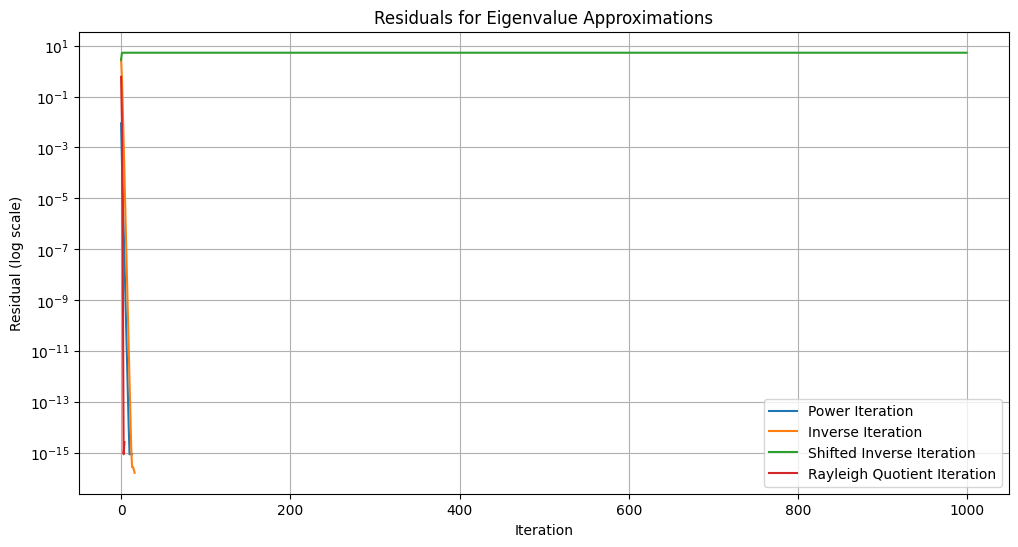

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr

# Power Iteration
def power_iteration_with_residuals(A, tol=1e-10, maxiter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    approximations = []

    for _ in range(maxiter):
        w = np.dot(A, v)
        v_next = w / np.linalg.norm(w)
        approximations.append(np.dot(v.T, np.dot(A, v)))
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    return approximations

# Inverse Iteration
def inverse_iteration_with_residuals(A, tol=1e-10, maxiter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    approximations = []

    for _ in range(maxiter):
        w = np.linalg.solve(A, v)
        v_next = w / np.linalg.norm(w)
        approximations.append(np.dot(v.T, np.dot(A, v)))
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    return approximations

# Shifted Inverse Iteration
def shifted_inverse_iteration_with_residuals(A, shift, tol=1e-10, maxiter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    shifted_A = A - shift * np.eye(n)
    approximations = []

    for _ in range(maxiter):
        w = np.linalg.solve(shifted_A, v)
        v_next = w / np.linalg.norm(w)
        approximations.append(np.dot(v.T, np.dot(A, v)))
        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    return approximations

# Rayleigh Quotient Iteration
def rayleigh_quotient_iteration_with_residuals(A, tol=1e-10, maxiter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    lambda_approx = np.dot(v.T, np.dot(A, v))
    approximations = [lambda_approx]

    for _ in range(maxiter):
        shifted_A = A - lambda_approx * np.eye(n)

        try:
            w = np.linalg.solve(shifted_A, v)
        except np.linalg.LinAlgError:
            w = np.dot(np.linalg.pinv(shifted_A), v)

        v_next = w / np.linalg.norm(w)
        lambda_next = np.dot(v_next.T, np.dot(A, v_next))
        approximations.append(lambda_next)

        if abs(lambda_next - lambda_approx) < tol:
            break

        v, lambda_approx = v_next, lambda_next

    return approximations

# Plot Residuals
def plot_residuals(A):
    actual_eigenvalues, _ = np.linalg.eig(A)
    actual_max = max(actual_eigenvalues)
    actual_min = min(actual_eigenvalues)

    # Run algorithms
    power_residuals = [abs(approx - actual_max) for approx in power_iteration_with_residuals(A)]
    inverse_residuals = [abs(approx - actual_min) for approx in inverse_iteration_with_residuals(A)]
    shifted_residuals = [abs(approx - actual_min) for approx in shifted_inverse_iteration_with_residuals(A, shift=6)]
    rayleigh_residuals = [abs(approx - actual_max) for approx in rayleigh_quotient_iteration_with_residuals(A)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.semilogy(power_residuals, label="Power Iteration")
    plt.semilogy(inverse_residuals, label="Inverse Iteration")
    plt.semilogy(shifted_residuals, label="Shifted Inverse Iteration")
    plt.semilogy(rayleigh_residuals, label="Rayleigh Quotient Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Residual (log scale)")
    plt.title("Residuals for Eigenvalue Approximations")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Use a larger 4x4 or 10x10 symmetric matrix
#     data = [
#     [21, 7, 19, 16, 11, 8, 18, 21, 19, 20, 6, 28, 5, 6, 19, 18, 2, 3, 3, 5],
#     [23, 12, 19, 23, 11, 28, 18, 26, 2, 13, 10, 23, 16, 5, 21, 19, 9, 5, 15, 4],
#     [19, 6, 26, 28, 19, 22, 2, 28, 20, 16, 2, 18, 27, 24, 19, 15, 3, 26, 9, 6],
#     [5, 1, 22, 23, 28, 17, 25, 4, 22, 20, 8, 11, 18, 20, 12, 7, 25, 19, 26, 29],
#     [4, 29, 0, 29, 3, 2, 23, 1, 8, 5, 0, 0, 8, 11, 10, 10, 3, 23, 16, 7],
#     [15, 7, 0, 27, 15, 7, 22, 16, 9, 27, 8, 15, 6, 7, 27, 17, 20, 6, 17, 5],
#     [7, 16, 19, 23, 24, 11, 27, 3, 4, 1, 28, 0, 15, 2, 4, 29, 2, 0, 1, 5],
#     [26, 2, 27, 22, 15, 28, 19, 24, 6, 6, 12, 24, 28, 5, 11, 20, 26, 6, 9, 2],
#     [11, 27, 14, 19, 7, 14, 18, 15, 12, 26, 28, 4, 18, 0, 13, 16, 0, 14, 14, 4],
#     [22, 20, 17, 21, 27, 24, 20, 7, 19, 9, 25, 17, 26, 28, 20, 6, 23, 8, 3, 16],
#     [19, 13, 2, 23, 28, 22, 1, 13, 14, 23, 11, 15, 13, 16, 7, 14, 9, 9, 25, 29],
#     [16, 4, 2, 12, 29, 25, 1, 9, 11, 9, 26, 15, 17, 12, 29, 17, 25, 22, 11, 28],
#     [21, 24, 21, 5, 20, 6, 6, 2, 26, 22, 0, 16, 1, 11, 10, 28, 23, 16, 23, 21],
#     [17, 17, 19, 1, 14, 27, 1, 26, 0, 0, 3, 15, 3, 28, 24, 29, 25, 28, 5, 6],
#     [12, 10, 25, 12, 21, 25, 14, 18, 15, 6, 28, 14, 0, 22, 18, 13, 22, 29, 18, 4],
#     [20, 10, 27, 2, 20, 21, 17, 1, 2, 14, 16, 2, 14, 11, 18, 19, 26, 15, 8, 27],
#     [10, 13, 22, 11, 9, 6, 18, 21, 13, 27, 29, 23, 13, 9, 0, 7, 28, 0, 7, 4],
#     [5, 26, 20, 2, 10, 21, 11, 8, 16, 16, 19, 27, 29, 1, 26, 23, 12, 4, 24, 22],
#     [25, 16, 11, 27, 18, 12, 20, 24, 6, 26, 5, 23, 26, 8, 22, 29, 6, 8, 29, 3],
#     [12, 24, 18, 8, 5, 24, 12, 22, 28, 25, 5, 4, 16, 3, 5, 18, 12, 11, 9, 7]
# ]
    A = np.random.randint(0, 30, (3, 3))
    A=[[1,2,3],[0,2,3],[0,0,4]]
    A = np.array(A)
    for i in A:
      print(*i)
    A = (A + A.T) / 2  # Symmetrize to ensure real eigenvalues
    plot_residuals(A)

In [41]:
B=A
print(B)

[[21.  15.  19.  10.5  7.5 11.5 12.5 23.5 15.  21.  12.5 22.  13.  11.5
  15.5 19.   6.   4.  14.   8.5]
 [15.  12.  12.5 12.  20.  17.5 17.  14.  14.5 16.5 11.5 13.5 20.  11.
  15.5 14.5 11.  15.5 15.5 14. ]
 [19.  12.5 26.  25.   9.5 11.  10.5 27.5 17.  16.5  2.  10.  24.  21.5
  22.  21.  12.5 23.  10.  12. ]
 [10.5 12.  25.  23.  28.5 22.  24.  13.  20.5 20.5 15.5 11.5 11.5 10.5
  12.   4.5 18.  10.5 26.5 18.5]
 [ 7.5 20.   9.5 28.5  3.   8.5 23.5  8.   7.5 16.  14.  14.5 14.  12.5
  15.5 15.   6.  16.5 17.   6. ]
 [11.5 17.5 11.  22.   8.5  7.  16.5 22.  11.5 25.5 15.  20.   6.  17.
  26.  19.  13.  13.5 14.5 14.5]
 [12.5 17.  10.5 24.  23.5 16.5 27.  11.  11.  10.5 14.5  0.5 10.5  1.5
   9.  23.  10.   5.5 10.5  8.5]
 [23.5 14.  27.5 13.   8.  22.  11.  24.  10.5  6.5 12.5 16.5 15.  15.5
  14.5 10.5 23.5  7.  16.5 12. ]
 [15.  14.5 17.  20.5  7.5 11.5 11.  10.5 12.  22.5 21.   7.5 22.   0.
  14.   9.   6.5 15.  10.  16. ]
 [21.  16.5 16.5 20.5 16.  25.5 10.5  6.5 22.5  9.  24.  1